In [1]:
from os.path import dirname, basename, exists, expanduser, join
from glob import glob
import numpy as np
import copy

import matplotlib.pyplot as plt
from matplotlib import colormaps

import rasterio
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr

In [2]:
def reproject_to_match(img_to_repro, ref_img, out_fp):
    kwargs = img_to_repro.meta.copy()
    kwargs.update({
        'crs': ref_img.crs,
        'transform': ref_img.transform,
        'width': ref_img.width,
        'height': ref_img.height
    })

    with rasterio.open(out_fp, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(img_to_repro, 1),
            destination=rasterio.band(dst, 1),
            src_transform=img_to_repro.transform,
            src_crs=img_to_repro.crs,
            dst_transform=ref_img.transform,
            dst_crs=ref_img.crs,
            resampling=Resampling.nearest)

    return out_fp

def get_dates(fp):
    return jpl_dic[basename(fp).split('.')[0]]

def add_extension(fp, new_ext):
    old_ext = fp.split('.')[-1]
    return join(dirname(fp) , basename(fp.replace(old_ext, f'{new_ext}.{old_ext}')))

In [3]:
data_dir = '/scratch/zacharykeskinen'
jpl_dic = {'lowman_23205_20002-007_20007-003_0013d_s01_L090HH_01':('2020-01-31','2020-02-13'),'lowman_23205_20007-003_20011-003_0008d_s01_L090HH_01':('2020-02-13','2020-02-21'),'lowman_23205_20011-003_20016-004_0019d_s01_L090HH_01':('2020-02-21','2020-03-11')}
jpl_unw = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*unw.grd.tiff'))
jpl_unw = [i for i in jpl_unw if basename(i).split('.')[0] in jpl_dic.keys()]
jpl_cor = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*cor.grd.tiff'))
jpl_cor = [i for i in jpl_cor if basename(i).split('.')[0] in jpl_dic.keys()]
isce_unw = glob(join(data_dir, 'merge_v2','*unw.tif'))
isce_cor = glob(join(data_dir, 'merge_v2','*cor.tif'))

In [4]:
## Run to reproject

# for im in jpl_cor:
#     with rio.open(im) as src:
#         dates = get_dates(im)
#         date0 = dates[0].replace('-','')
#         date1 = dates[1].replace('-','')
#         isce_fp = f'/scratch/zacharykeskinen/merge_v2/merged_{date0}_{date1}.cor.tif'
#         show(src)
#         with rio.open(isce_fp) as src2:
#             show(src2)
#             isce = src2.read(1)
#             out_fp = add_extension(im, 'isce.repro')
#             out_fp = reproject_to_match(src, src2, out_fp)
#     with rio.open(out_fp) as src_match:
#         jpl = src_match.read(1)
#         show(src_match)

# for im in jpl_unw:
#     with rio.open(im) as src:
#         dates = get_dates(im)
#         date0 = dates[0].replace('-','')
#         date1 = dates[1].replace('-','')
#         isce_fp = f'/scratch/zacharykeskinen/merge_v2/merged_{date0}_{date1}.unw.tif'
#         show(src)
#         with rio.open(isce_fp) as src2:
#             show(src2)
#             isce = src2.read(1)
#             out_fp = add_extension(im, 'isce.repro')
#             out_fp = reproject_to_match(src, src2, out_fp)
#     with rio.open(out_fp) as src_match:
#         jpl = src_match.read(1)
#         show(src_match)

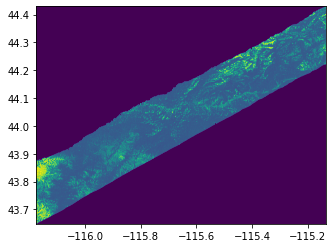

In [5]:
f, ax = plt.subplots()
with rio.open(isce_cor[0]) as src_match:
    jpl = src_match.read(1)
    show(src_match, ax = ax)
    x_labs = ax.get_xticklabels()
    x_locs = ax.get_xticks()
    y_locs = ax.get_yticks()

## Create Dictionary for each pair to compare

In [6]:
jpl_unw_repo = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*unw.grd.isce.repro.tiff'))
jpl_cor_repo = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*cor.grd.isce.repro.tiff'))

In [7]:
jpl_dates = [f'{get_dates(im)[0]}_{get_dates(im)[1]}'.replace('-','') for im in jpl_cor_repo]
comb_imgs = {}
for date in jpl_dates:
    d = {}
    for list in [isce_cor, isce_unw]:
        imgs = [im for im in list if date in im]
        if imgs:
            if list == isce_cor:
                d['isce_cor'] = [im for im in isce_cor if date in im][0]
            else:
                d['isce_unw'] = [im for im in isce_unw if date in im][0]
    for list in [jpl_cor_repo, jpl_unw_repo]:
        imgs = [im for im in jpl_unw_repo if date == f'{get_dates(im)[0]}_{get_dates(im)[1]}'.replace('-','')]
        if imgs:
            if list == jpl_cor_repo:
                d['jpl_cor'] = [im for im in jpl_unw_repo if date == f'{get_dates(im)[0]}_{get_dates(im)[1]}'.replace('-','')][0]
            else:
                d['jpl_unw'] = [im for im in jpl_unw_repo if date == f'{get_dates(im)[0]}_{get_dates(im)[1]}'.replace('-','')][0]

    comb_imgs[date] = d

20200221_20200311
20200213_20200221
20200131_20200213


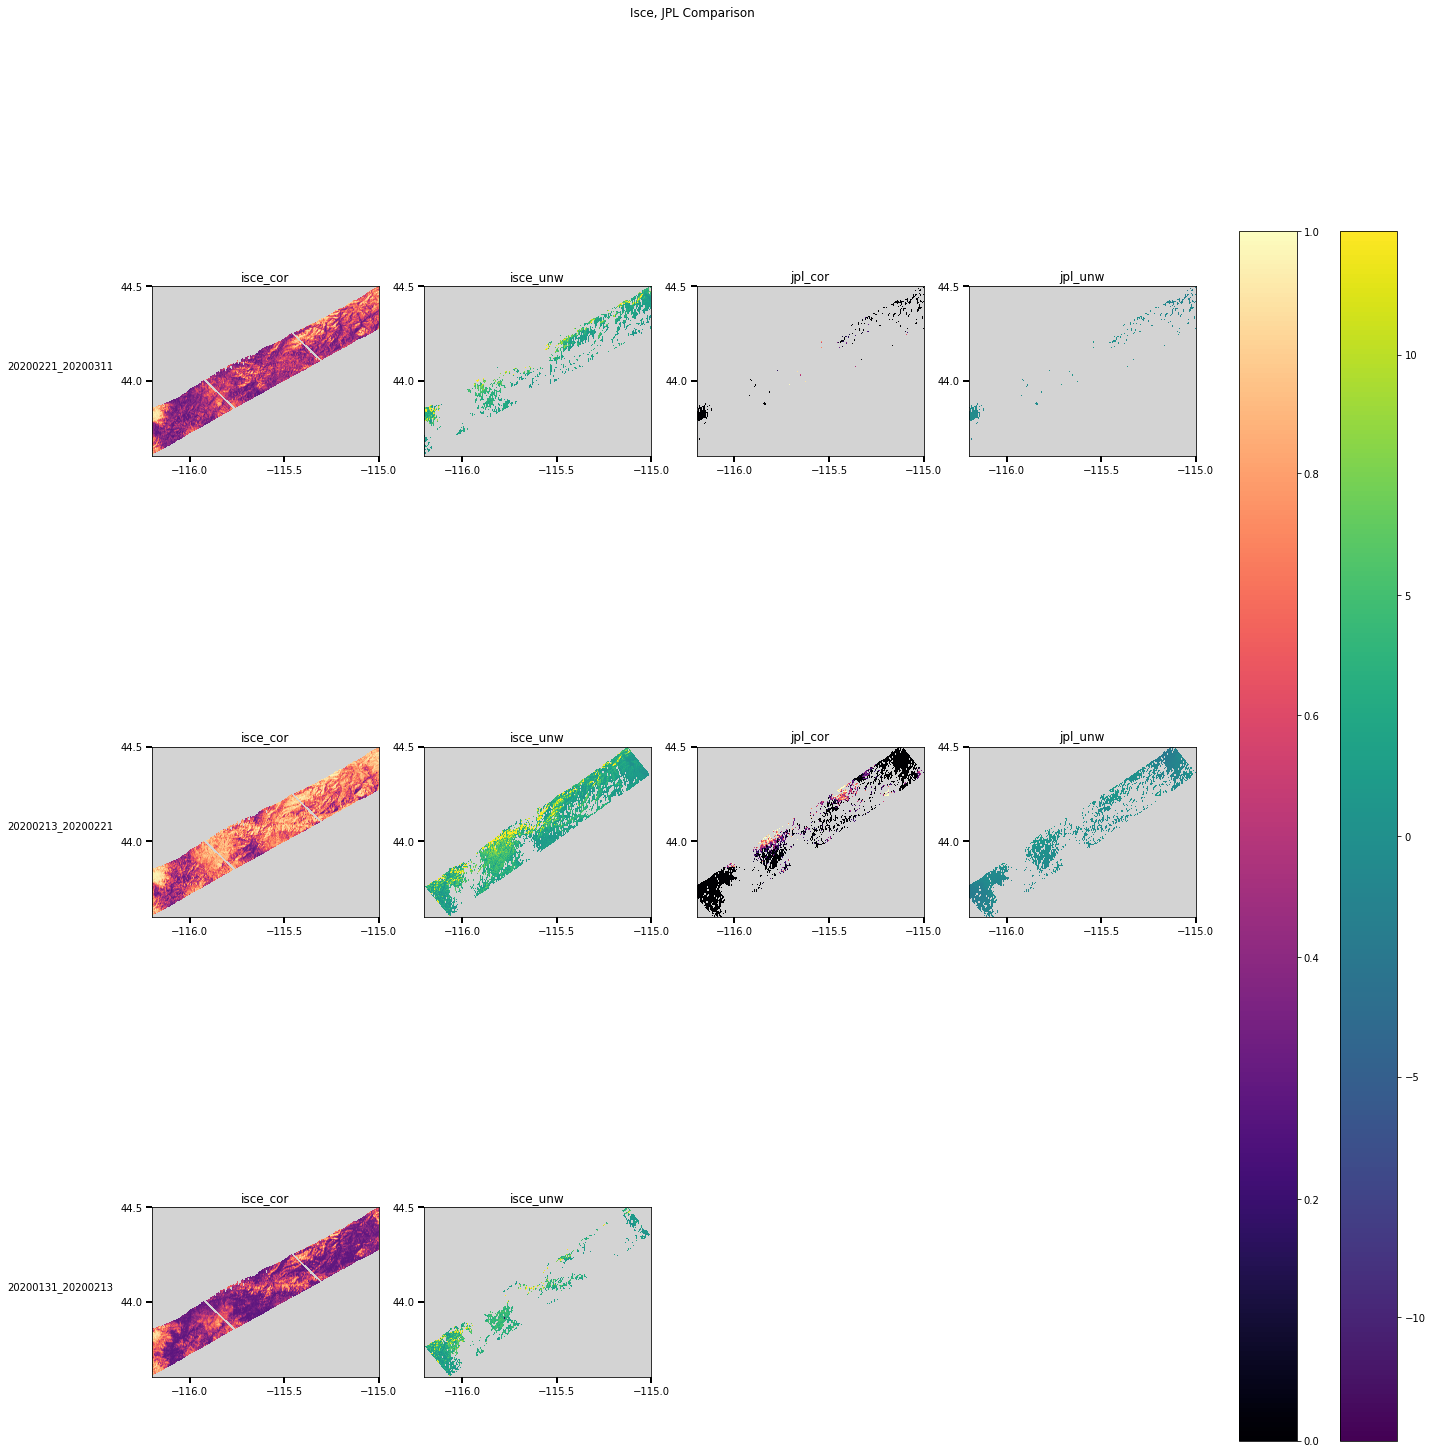

In [9]:
fig, axs = plt.subplots(3, 4, figsize = (20,24))

fig.suptitle('Isce, JPL Comparison')
cmap_unw = copy.deepcopy(colormaps['viridis'])
cmap_unw.set_bad(color="lightgrey")

cmap_cor = copy.deepcopy(colormaps['magma'])
cmap_cor.set_bad(color="lightgrey")

for j, (day, imgs) in enumerate(comb_imgs.items()):
    print(day)
    if j == j:
        for i, (im_type, fp) in enumerate(imgs.items()):
            ax = axs[j,i]
            if i == i:
                with rio.open(fp) as src:
                    arr = src.read(1)
                arr = np.ma.masked_where(arr==0, arr)
                if 'cor' in im_type:
                    corIm = ax.imshow(arr, vmin = 0, vmax = 1, cmap = cmap_cor, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
                else:
                    unwIm = ax.imshow(arr, vmin = -4*np.pi, vmax = 4*np.pi, cmap = cmap_unw, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
                ax.set_title(im_type)
                ax.tick_params(direction='out', length=6, width=2, colors='k', grid_color='k', grid_alpha=0.5)
                ax.locator_params(tight=True, nbins=3)
            if i == 0:
                ax.set_ylabel(day, rotation=0, fontsize=10, labelpad=60)
fig.delaxes(axs[2,2])
fig.delaxes(axs[2,3])
# add colorbars
fig.subplots_adjust(right=0.85)
left = 0.88
bottom = 0.15
width = 0.04
height = 0.7
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(corIm, cax=cbar_ax)
# add colorbars
left = 0.95
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(unwIm, cax=cbar_ax)

plt.savefig('isce_jpl_compare_v1.png')

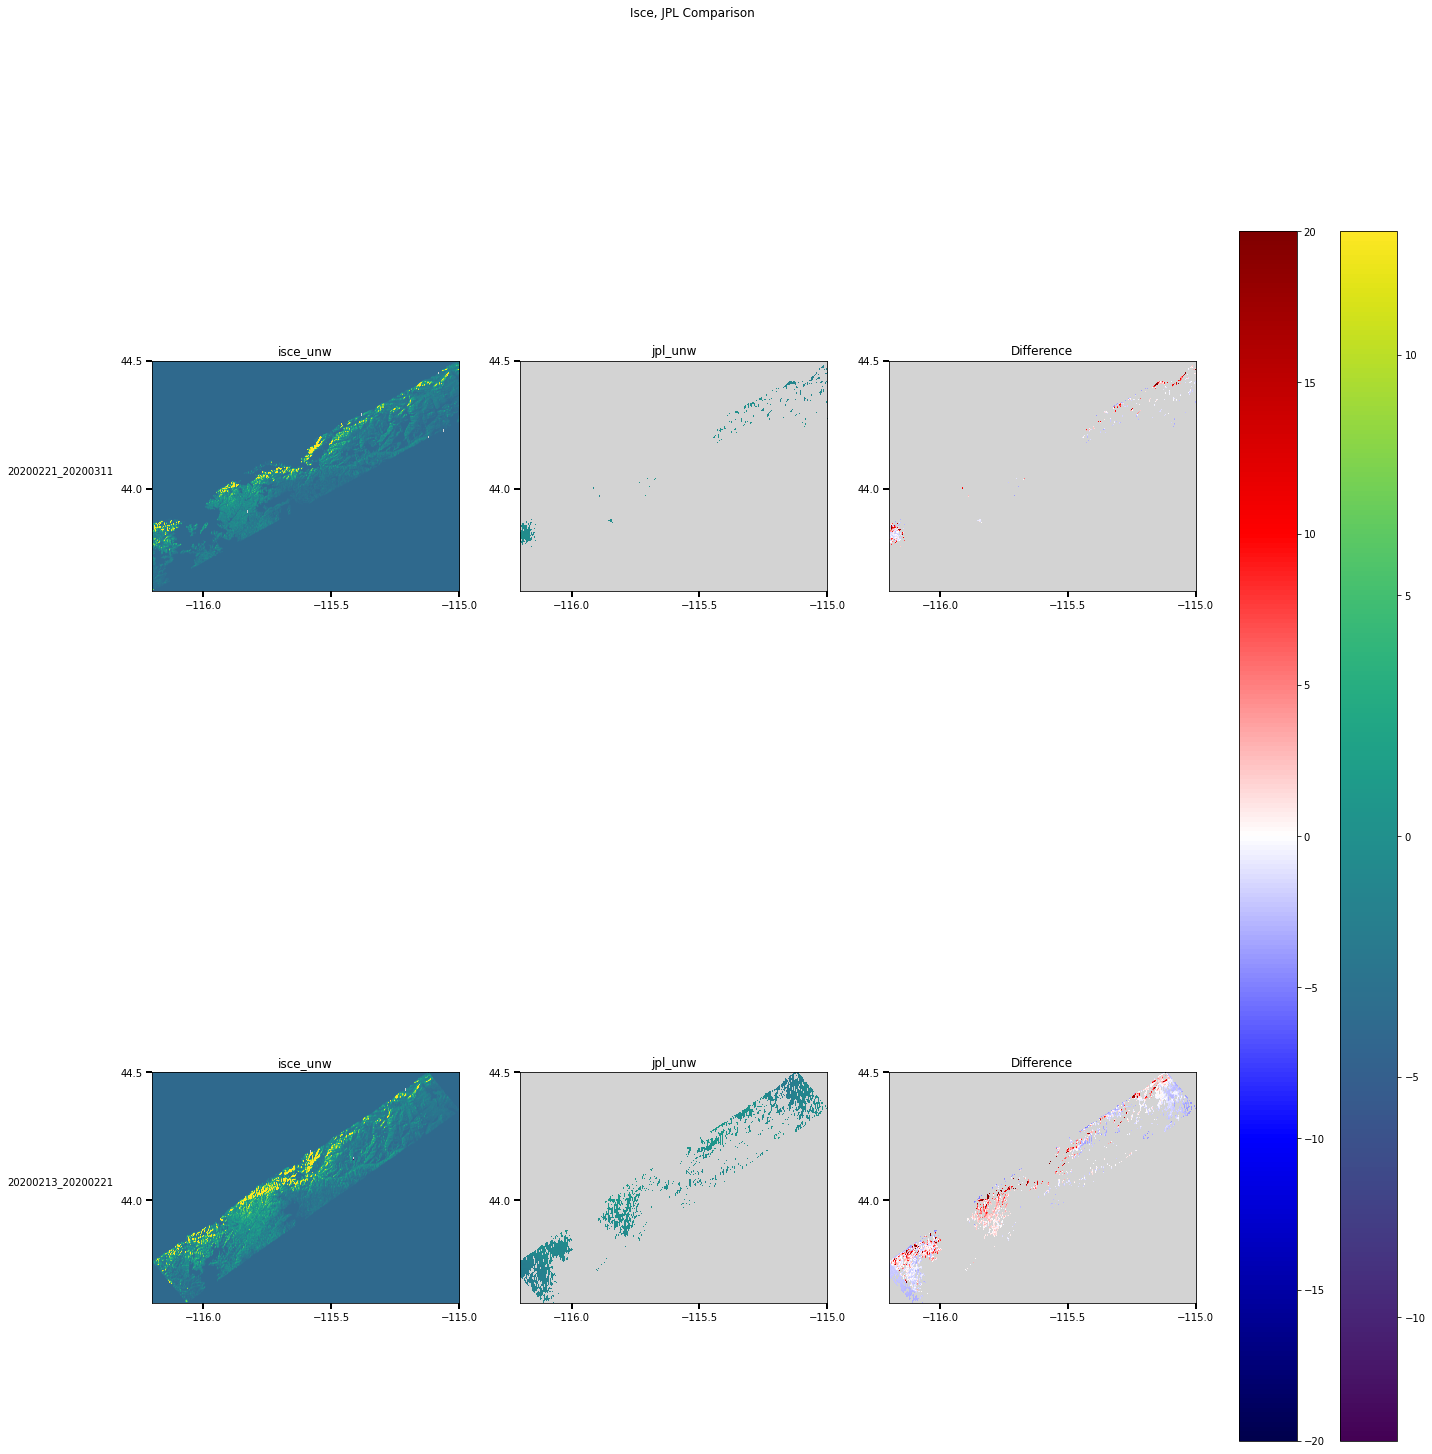

In [10]:
fig, axs = plt.subplots(2, 3, figsize = (20,24))

fig.suptitle('Isce, JPL Comparison')
cmap_unw = copy.deepcopy(colormaps['viridis'])
cmap_unw.set_bad(color="lightgrey")

cmap_diff = copy.deepcopy(colormaps['seismic'])
cmap_diff.set_bad(color="lightgrey")

constant = -4
n = 1

for j, (day, imgs) in enumerate(comb_imgs.items()):
    if day != '20200131_20200213':
        for i, (im_type, fp) in enumerate(imgs.items()):
            if 'unw' in im_type and 'isce' in im_type:
                ax = axs[j,0]
                with rio.open(fp) as src:
                    isce_arr = src.read(1)[::n,::n]
                isce_arr = isce_arr + constant
                isce_arr = np.ma.masked_where(isce_arr==constant, isce_arr)
                isce_arr = np.ma.masked_where(isce_arr<-1e33, isce_arr)
                isce_arr = np.ma.masked_where(isce_arr>1e33, isce_arr)
                isce_arr = gaussian_filter(isce_arr, 2)

                unwIm = ax.imshow(isce_arr, vmin = -4*np.pi, vmax = 4*np.pi, cmap = cmap_unw, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
                ax.set_title(im_type)
                ax.tick_params(direction='out', length=6, width=2, colors='k', grid_color='k', grid_alpha=0.5)
                ax.locator_params(tight=True, nbins=3)
                ax.set_ylabel(day, rotation=0, fontsize=10, labelpad=60)
            elif 'unw' in im_type and 'jpl' in im_type:
                ax = axs[j,1]
                with rio.open(fp) as src:
                    jpl_arr = src.read(1)[::n,::n]
                # jpl_arr = np.ma.masked_where(jpl_arr==0, jpl_arr)
                jpl_arr = gaussian_filter(jpl_arr, 2)


                unwIm = ax.imshow(jpl_arr, vmin = -4*np.pi, vmax = 4*np.pi, cmap = cmap_unw, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
                ax.set_title(im_type)
                ax.tick_params(direction='out', length=6, width=2, colors='k', grid_color='k', grid_alpha=0.5)
                ax.locator_params(tight=True, nbins=3)
        diff = isce_arr - jpl_arr
        diff_pi = diff / (2*np.pi)
        ax = axs[j,2]
        diffIm = ax.imshow(diff, vmin = -20, vmax = 20, cmap = cmap_diff, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
        ax.set_title('Difference')
        ax.tick_params(direction='out', length=6, width=2, colors='k', grid_color='k', grid_alpha=0.5)
        ax.locator_params(tight=True, nbins=3)
                
# add colorbars
fig.subplots_adjust(right=0.85)
left = 0.88
bottom = 0.15
width = 0.04
height = 0.7
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(diffIm, cax=cbar_ax)
# add colorbars
left = 0.95
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(unwIm, cax=cbar_ax)

plt.savefig('isce_jpl_diff.png')

In [ ]:
fig, axs = plt.subplots(2, figsize = (20,24))
constant = -4
n = 1

fig.suptitle('Isce, JPL Comparison')

for j, (day, imgs) in enumerate(comb_imgs.items()):
    if day != '20200131_20200213':
        for i, (im_type, fp) in enumerate(imgs.items()):

            if 'unw' in im_type and 'isce' in im_type:
                with rio.open(fp) as src:
                    isce_arr = src.read(1)
                isce_arr = isce_arr[::n,::n] + constant
                isce_arr = gaussian_filter(isce_arr, 4)
                isce_arr = np.ma.masked_where(isce_arr==constant, isce_arr)
                isce_arr = np.ma.masked_where(isce_arr<-1e9, isce_arr)
                isce_arr = np.ma.masked_where(isce_arr>1e9, isce_arr)
                unwIm = ax.imshow(isce_arr, vmin = -4*np.pi, vmax = 4*np.pi, cmap = cmap_unw, extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))

            elif 'unw' in im_type and 'jpl' in im_type:
                with rio.open(fp) as src:
                    jpl_arr = src.read(1)
                jpl_arr = jpl_arr[::n,::n]
                jpl_arr = gaussian_filter(jpl_arr, 4)
                # jpl_arr = np.ma.masked_where(jpl_arr==0, jpl_arr)
                jpl_arr = np.ma.masked_where(jpl_arr<-1e9, jpl_arr)
                jpl_arr = np.ma.masked_where(jpl_arr>1e9, jpl_arr)
        
        isce_arr = isce_arr[jpl_arr.mask == False]
        jpl_arr = jpl_arr[jpl_arr.mask == False]
        # isce_arr = np.ma.masked_where(jpl_arr == np.nan, isce_arr)
        # jpl_arr = np.ma.masked_where(isce_arr == np.nan, jpl_arr)

        axs[j].scatter(isce_arr, jpl_arr, alpha = 0.1)
        #print(pearsonr(jpl_arr, isce_arr)[0])
        axs[j].set_xlim(-6.1,6.1)
        axs[j].set_ylim(-6.1,6.1)

plt.savefig('/scratch/zacharykeskinen/figures/isce_jpl_compare')